# Probabilistic Programming 4: Gaussian dynamical systems
## Monte Carlo sampling

### Preliminaries

- Goal 
  - Learn to apply Turing to a dynamical system.
- Materials        
  - Mandatory
    - These lecture notes.    
  - Optional
      - [Probabilistic Programming notebook](https://github.com/bertdv/BMLIP/tree/master/lessons/notebooks/probprog/Probabilistic-Programming.ipynb)
      - David Blei (https://doi.org/10.1146/annurev-statistics-022513-115657)

In [ ]:
# Package managing
using Pkg
Pkg.activate("../../notebooks/probprog/workspace")
Pkg.instantiate()

using Logging; disable_logging(LogLevel(0))
using Distributions
using StatsPlots
using MCMCChains
using Turing; Turing.setadbackend(:forward_diff);
using Plots
pyplot();

## Data generation

In this notebook, we will be considering continuous state-space models. We will focus on the simplest form: the Gaussian dynamical system:

$$\begin{align}
x_k =&\ A x_{k-1} + q_{k-1} \\
y_k =&\ B x_k + r_k \, ,
\end{align}$$

where $x_k \in \mathbb{R}^{N}$ is the state, $y_k \in \mathbb{R}^{M}$ is the measurement. Process noise and measurement noise are assumed to be zero mean Gaussian with covariance matrices $Q$ and $R$ respectively. 

We'll generate the data in the same manner as the HMM setting. We start with an initial state $x_0$, apply the state transition $Ax_0$, and add Gaussian noise $q_0$. We then take the current state $x_1$, apply the emission transformation $B x_1$ and add Gaussian noise again $r_1$. This is repeated until we've reached $T$ observations.

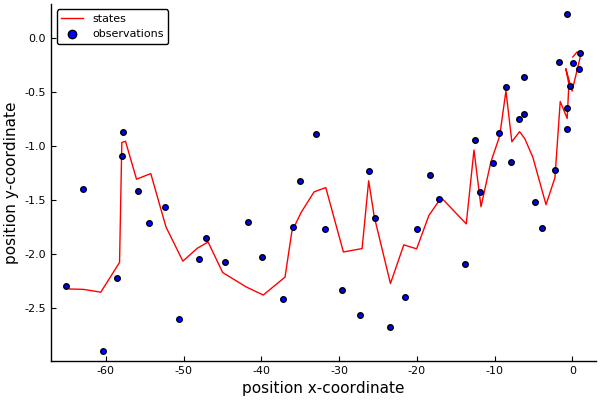

In [2]:
# Dimensionalities
N = 2
M = 2

# Length of time-series
T = 50

# Transition matrix of latent variables
transition = [1.0 0.0;
              0.0 1.0]

# Emission matrix for observed variables
emission = [1.0 0.0;
            0.0 1.0]

# Process noise (latent variables)
process_noise = [0.2 0.0;
                 0.0 0.1]

# Measurement noise (observations)
measurement_noise = [0.1 0.0;
                     0.0 0.1]

# Preallocate data arrays
states = zeros(2,T)
observations = zeros(2,T)

# Initial state
state_0 = [0., 0.]

# Keep previous state in memory
state_tmin = state_0

# Generate data for entire time-series
for t = 1:T
    
    # Transition from previous state
    states[:,t] = rand(MvNormal(transition * state_tmin, process_noise), 1)[:,1]
    
    # Emission of current state
    observations[:,t] = rand(MvNormal(emission * states[:,t], measurement_noise), 1)[:,1]
    
    # Update previous state
    state_tmin = states[:,t]
    
end

# Visualization of states
plot(states[1,:], states[2,:], color="red", label="states", grid=false, xlabel="position x-coordinate", ylabel="position y-coordinate")
scatter!(observations[1,:], observations[2,:], color="blue", label="observations")

Since we don't have a time-axis anymore, it is hard to see how the process evolves. Animating the path is helpful in this regard.

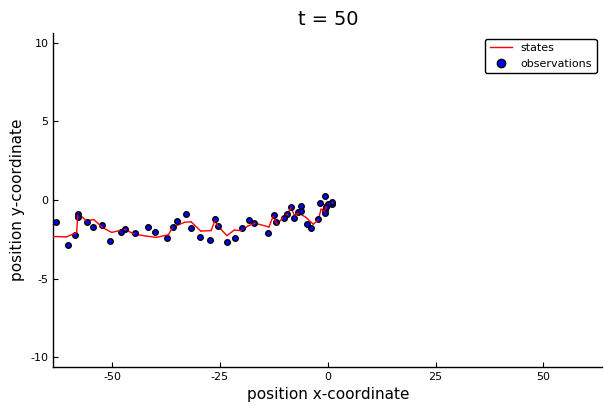

Plots.AnimatedGif("/home/wmkouw/Dropbox/Courses/tueindhoven/5SSD0 - Bayesian Machine Learning & Information Processing/tmp/BMLIP/lessons/exercises/probprog_solutions/example-GDS.gif")
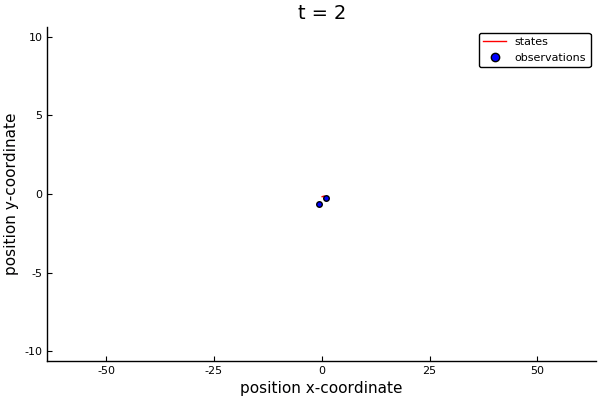

In [3]:
"Animation of cart's path"

# Plot initial state
plot([states[1,1]], [states[2,1]], 
     color="red", 
     label="states", 
     grid=false, 
     xlabel="position x-coordinate", 
     ylabel="position y-coordinate", 
     xlims=[-60,60], 
     ylims=[-10,10])

# Plot initial observation
scatter!([observations[1,1]], [observations[2,1]], color="blue", label="observations")

anim = @animate for t = 2:T
    
    title!("t = "*string(t))
    
    # Plot new state
    plot!([states[1,t-1:t]], [states[2,t-1:t]], color="red", label="")
    
    # Plot new observation
    scatter!([observations[1,t]], [observations[2,t]], color="blue", label="")
    
end

gif(anim, "example-GDS.gif", fps = 3)

## Model specification

The Bayesian formulation of the LGDS state-space model takes the following form:

$$\begin{align}
p(x_k \mid x_{k-1}) =&\ \mathcal{N}(x_k \mid A x_{k-1}, Q)\\
p(y_k \mid x_k) =&\ \mathcal{N}(y_k \mid B x_k, R) \, .
\end{align}$$

We can easily specify the states and observations as multivariate Gaussian distributions. If we do not know the process and measurement noise matrices, we can add Wishart priors to them. Similarly, if we don't know the transition and emission matrices, we can priors for them as well. Since these can take on negative values, we would specify them as multivariate Gaussians;

$$\begin{align}
p(Q) \sim&\ \mathcal{W}(V_Q, n_Q) \\
p(R) \sim&\ \mathcal{W}(V_R, n_R) \\
p(A) \sim&\ \mathcal{N}(m_A, S_A) \\
p(B) \sim&\ \mathcal{N}(m_B, S_B) \, .
\end{align}$$

These are all known distributions to sample from, and they are locally conjugate. However, a Gibbs sampler can be extremely slow in a time-series setting. Plus, with some component samplers, such as Particle Gibss, errors can propogate forward through the time-series, resulting in drifting estimates. We will run an agnostic MCMC procedure in this situation.

Again, we start simple and slowly improve the model.

### Model 1: estimate states

We will first assume we know the transition and emission matrices, as well as measurement and process noises. Based on these, we purely want to estimate states from observations.

In [4]:
@model Gaussian_dynamical_system(y, A, Q, B, R) = begin
    "This model implicitly assumes 2-dim states and 2-dim observations"
    
    # Time-series length
    T = size(y, 2)

    # State sequence.
    x = Vector{Vector}(undef, T)

    # Define initial state
    x_0 ~ MvNormal([0., 0.], [1. 0.;0. 1.])
    
    # Initialize previous state
    x_tmin = x_0

    # Loop over entire sequence
    for t = 1:T
        
        # State transition     
        x[t] ~ MvNormal(A * x_tmin, Q)
        
        # Observation emission
        y[:,t] ~ MvNormal(B * x[t], R)
        
        # Update previous state
        x_tmin = x[t]
    end
end

# Call instance of the model
model1 = Gaussian_dynamical_system(observations, transition, process_noise, emission, measurement_noise);

We will use a "No U-Turn Sampler". Its parameters are the number of samples to "burn" and the acceptance ratio of the walk.

In [5]:
# NUTS logger is cumbersome
Turing.turnprogress(false)

# Length of chain
len_chain = 1000

# Define sampler
sampler1 = NUTS(200, 0.6)

# Call sampler
chain1 = sample(model1, sampler1, len_chain);

Let's look at the final state of the chain.

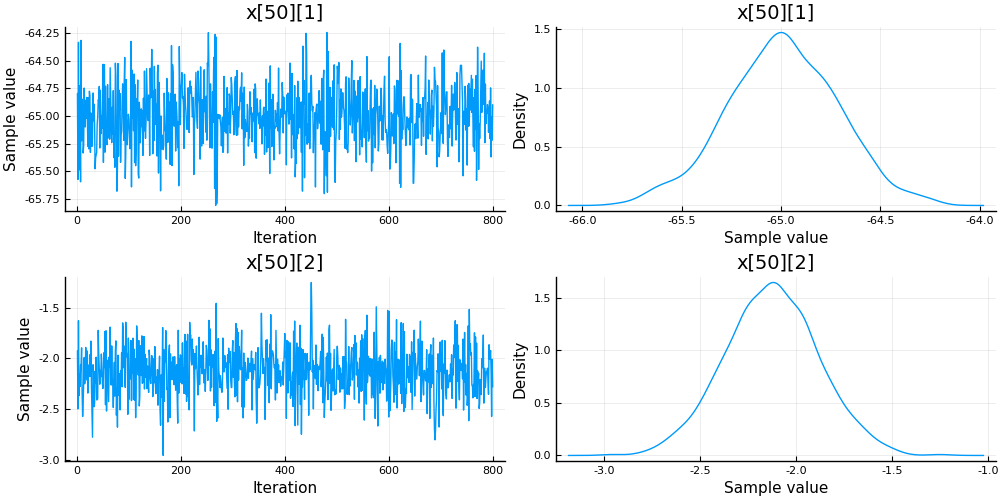

In [6]:
plot(chain1[Symbol("x["*string(T)*"]")])

And plot the inferred states.

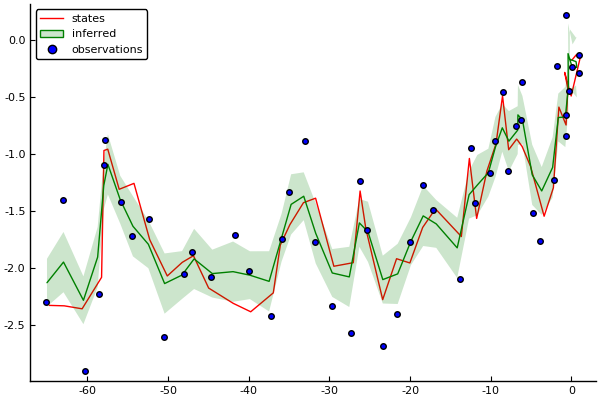

In [7]:
# Extract mean of the chain
x_estimated = reshape(mean(chain1[:x].value.data, dims=[1]), (2,50))

# Extract standard error of the mean
x_sem = reshape(std(chain1[:x].value.data, dims=[1]), (2,50))
x_sem[1,:] ./= sqrt.(range(1, stop=T))
x_sem[2,:] ./= sqrt.(range(1, stop=T));

# Visualization
plot(states[1,:], states[2,:], color="red", label="states", grid=false)
plot!(x_estimated[1,:], x_estimated[2,:], ribbon=[x_sem, x_sem], fillalpha=0.2, color="green", label="inferred")
scatter!(observations[1,:], observations[2,:], color="blue", label="observations")

### Model 2: process noise estimation

We can extend the model to include process noise estimation. 

In [8]:
@model Gaussian_dynamical_system(y, A, B, R) = begin
    "This model implicitly assumes 2-dim states and 2-dim observations"
    
    # Time-series length
    T = size(y, 2)
    
    # Define prior for process noise
    Q ~ Wishart(2, [1. 0.;0. 1.])   

    # State sequence.
    x = Vector{Vector}(undef, T)

    # Define initial state
    x_0 ~ MvNormal([0., 0.], [1. 0.;0. 1.])
    
    # Initialize previous state
    x_tmin = x_0

    # Loop over entire sequence
    for t = 1:T
        
        # State transition     
        x[t] ~ MvNormal(A*x_tmin, Q)
        
        # Observation emission
        y[:,t] ~ MvNormal(B*x[t], R)
        
        # Update previous state
        x_tmin = x[t]
    end
end

# Call instance of the model
model2 = Gaussian_dynamical_system(observations, transition, emission, measurement_noise);

Stick to the NUTS sampler.

In [9]:
# Length of chain
len_chain = 1000

# Define sampler
sampler2 = NUTS(500, 0.6)

# Call sampler
chain2 = sample(model2, sampler2, len_chain);

Let's have a look at the state estimates. We expect them to be a worse fit compared to the previous run, because we have to estimate states and parameters jointly.

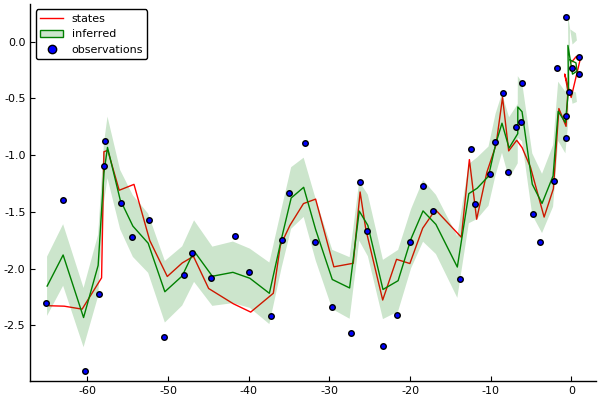

In [10]:
# Extract mean of the chain
x_estimated = reshape(mean(chain2[:x].value.data, dims=[1]), (2,50))

# Extract standard error of the mean
x_sem = reshape(std(chain2[:x].value.data, dims=[1]), (2,50))
x_sem[1,:] ./= sqrt.(range(1, stop=T))
x_sem[2,:] ./= sqrt.(range(1, stop=T));

# Visualization
plot(states[1,:], states[2,:], color="red", label="states", grid=false)
plot!(x_estimated[1,:], x_estimated[2,:], ribbon=[x_sem, x_sem], fillalpha=0.2, color="green", label="inferred")
scatter!(observations[1,:], observations[2,:], color="blue", label="observations")

Let's also have a look at the estimated process noise matrix.

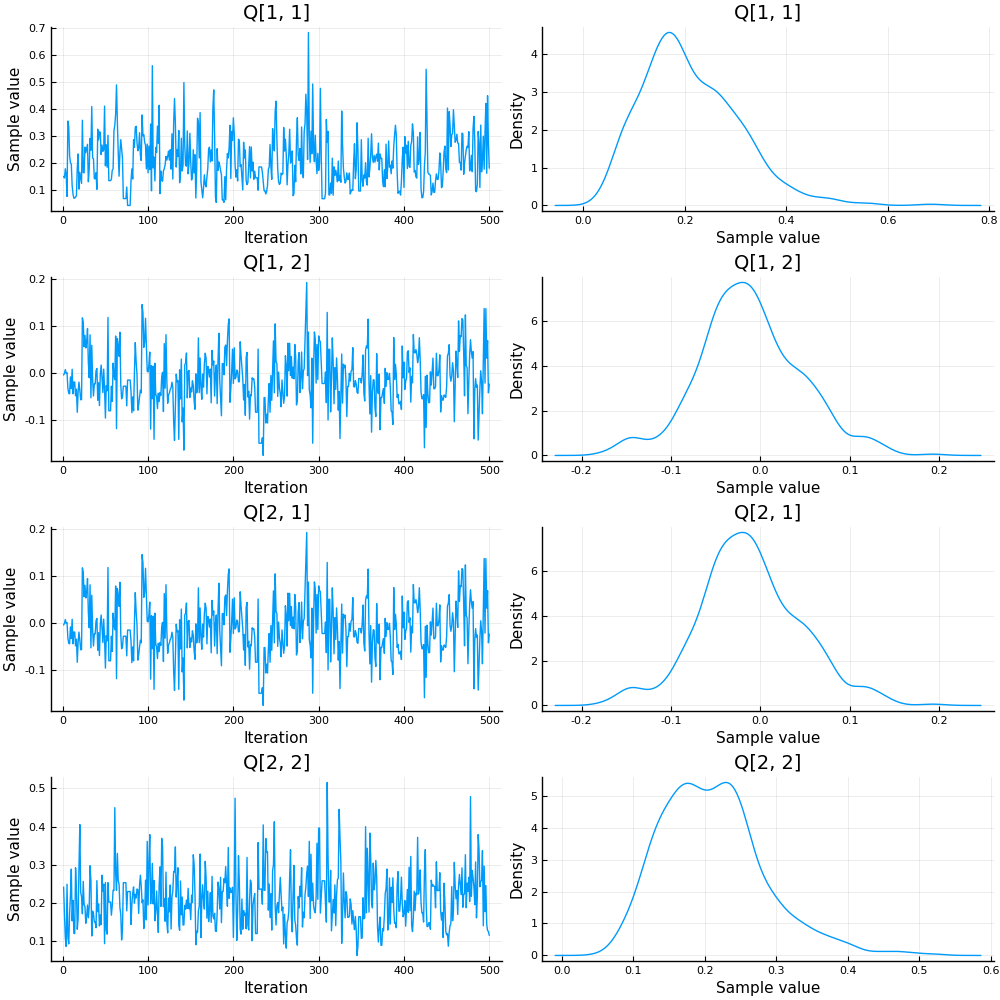

In [11]:
plot(chain2[:Q])

We'll use a bar plot to visualize the coefficients.

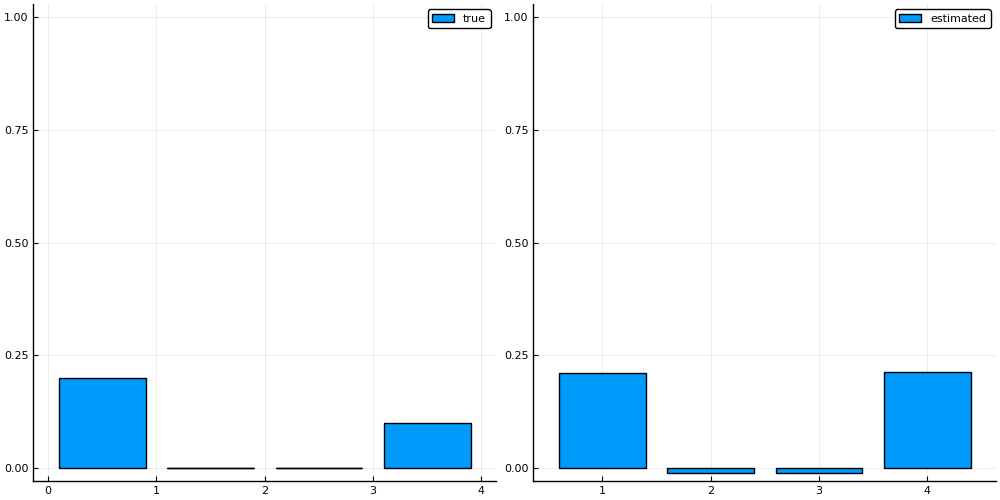

In [12]:
# Extract state estimates
pnoise_estimate = reshape(mean(chain2[:Q].value.data, dims=[1]), (2,2))

# Visualization
l = @layout [a b]
h1 = bar(0:4, reshape(process_noise, (4,)), label="true", ylims=[0., 1.])
h2 = bar(reshape(pnoise_estimate, (4,)), label="estimated", ylims=[0., 1.])
plot(h1, h2, layout=l, size=(1000,500))

### Assignment: transition matrix estimation

The transition matrix can be estimated in a similar fashion as the process noise matrix, except that it does not need to be positive semi-definite. Can you construct a model with states, process noise _and_ the transition matrix as free variables?

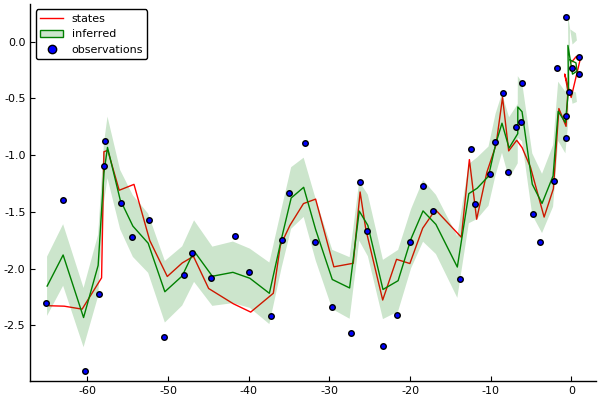

In [13]:
@model Gaussian_dynamical_system(y, B, R) = begin
    
    # Time-series length
    D, T = size(y)
    
    # Define prior for process noise
    Q ~ Wishart(2, [1. 0.;0. 1.])   
    
    # Preallocate transition matrix
    A = Vector{Vector}(undef, D)
    for d = 1:D
        A[d] ~ MvNormal([0., 0.], [1. 0.;0. 1.])
    end

    # State sequence.
    x = Vector{Vector}(undef, T)

    # Define initial state
    x_0 ~ MvNormal([0., 0.], [1. 0.;0. 1.])
    
    # Initialize previous state
    x_tmin = x_0

    # Loop over entire sequence
    for t = 1:T
        
        # State transition     
        x[t] ~ MvNormal([A[1]'*x_tmin, A[2]'*x_tmin], Q)
        
        # Observation emission
        y[:,t] ~ MvNormal(B * x[t], R)
        
        # Update previous state
        x_tmin = x[t]
    end
end

# Call instance of the model
model3 = Gaussian_dynamical_system(observations, emission, measurement_noise)

# Length of chain
len_chain = 1000

# Define sampler
sampler3 = NUTS(200, 0.6)

# Call sampler
chain3 = sample(model3, sampler3, len_chain);

# Extract mean of the chain
x_estimated = reshape(mean(chain2[:x].value.data, dims=[1]), (2,50))

# Extract standard error of the mean
x_sem = reshape(std(chain2[:x].value.data, dims=[1]), (2,50))
x_sem[1,:] ./= sqrt.(range(1, stop=T))
x_sem[2,:] ./= sqrt.(range(1, stop=T));

# Visualization
plot(states[1,:], states[2,:], color="red", label="states", grid=false)
plot!(x_estimated[1,:], x_estimated[2,:], ribbon=[x_sem, x_sem], fillalpha=0.2, color="green", label="inferred")
scatter!(observations[1,:], observations[2,:], color="blue", label="observations")

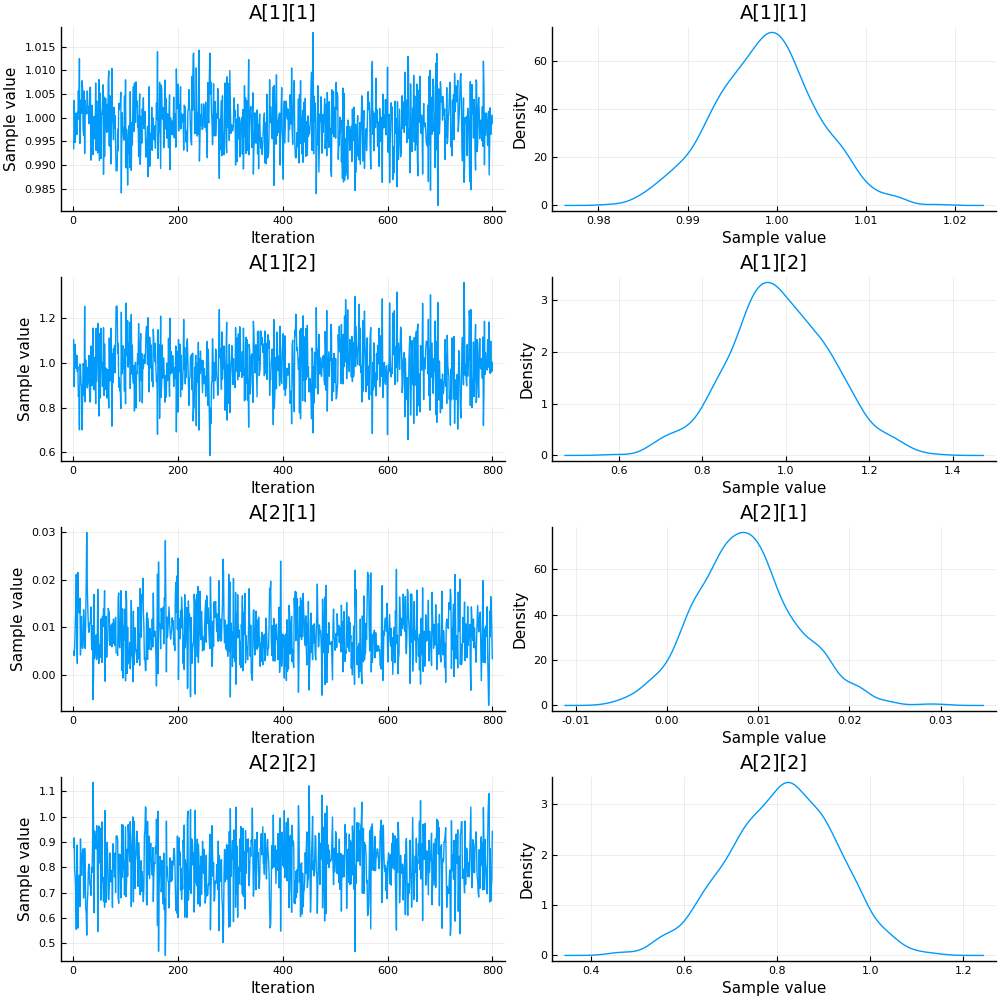

In [14]:
plot(chain3[:A])

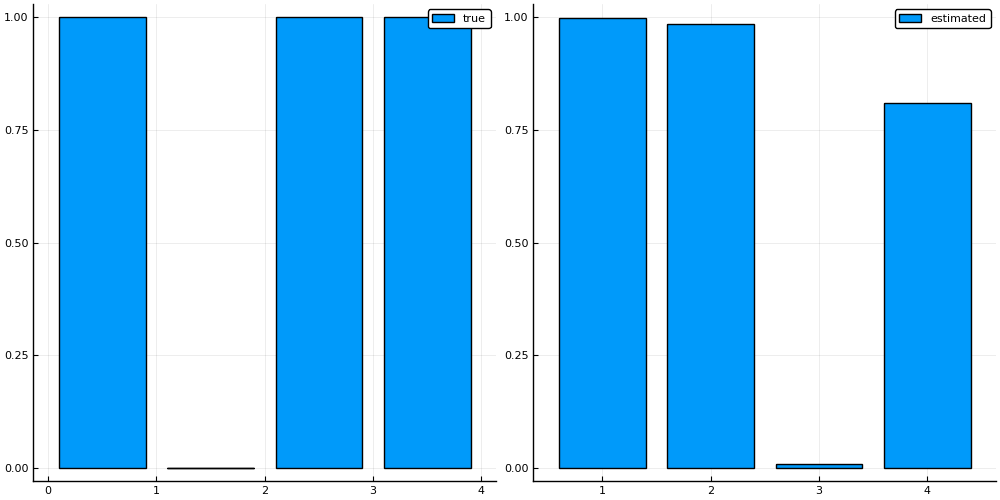

In [15]:
# Extract state estimates
transition_estimate = reshape(mean(chain3[:A].value.data, dims=[1]), (2,2))

# Visualization
l = @layout [a b]
h1 = bar(0:4, reshape(transition, (4,)), label="true", ylims=[0., 1.])
h2 = bar(reshape(transition_estimate, (4,)), label="estimated", ylims=[0., 1.])
plot(h1, h2, layout=l, size=(1000,500))